In [1]:
!pip install gym==0.23.1 einops fancy-einsum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install Pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://github.com/callummcdougall/arena-v1/raw/main/w6d3/utils.py
!wget https://github.com/callummcdougall/arena-v1/raw/main/w6d2/solutions.py

--2022-12-09 01:05:58--  https://github.com/callummcdougall/arena-v1/raw/main/w6d3/utils.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/callummcdougall/arena-v1/main/w6d3/utils.py [following]
--2022-12-09 01:05:58--  https://raw.githubusercontent.com/callummcdougall/arena-v1/main/w6d3/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 755 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     755  --.-KB/s    in 0s      

2022-12-09 01:05:58 (27.0 MB/s) - ‘utils.py’ saved [755/755]

--2022-12-09 01:05:58--  https://github.com/callummcdougall/arena-v1/raw

In [3]:
from dataclasses import dataclass
from typing import Optional, Union, List, Tuple
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw

import utils
from solutions import *

MAIN = __name__ == "__main__"

In [4]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [5]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

In [6]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''
    Base class for agents interacting with an environment (you do not need
    to add any implementation here)
    '''
    rng: np.random.Generator

    def __init__(self,
        env: DiscreteEnviroGym,
        config: AgentConfig = defaultConfig,
        gamma: float = 0.99, seed: int = 0
    ):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

In [7]:
class Cheater(Agent):
    def __init__(self,
        env: DiscreteEnviroGym,
        config: AgentConfig = defaultConfig,
        gamma=0.99, seed=0
    ):
        super().__init__(env, config, gamma, seed)
        self.pi_opt = find_optimal_policy(env.unwrapped.env, gamma)

    def get_action(self, obs):
        return self.pi_opt[obs]

100%|██████████| 100/100 [00:00<00:00, 4621.21it/s]


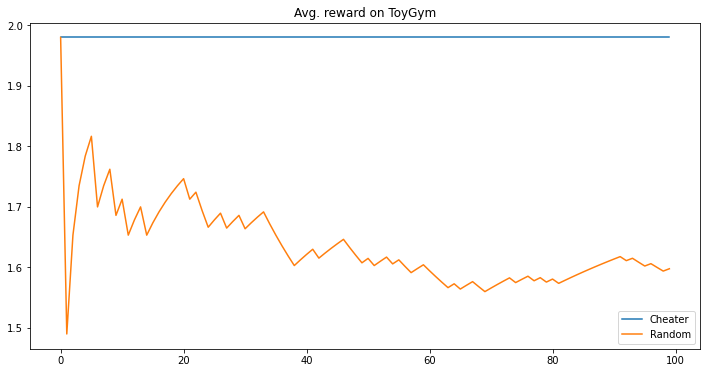

In [8]:
plt.figure(figsize=(12, 6))
env_toy = gym.make("ToyGym-v0")
agents_toy = [Cheater(env_toy), Random(env_toy)]
for agent in agents_toy:
    returns = agent.train(n_runs=100)
    plt.plot(utils.cummean(returns), label=agent.name)
plt.legend()
plt.title(f"Avg. reward on {env_toy.spec.name}")
plt.show()

In [74]:
class EpsilonGreedy(Agent):
    '''
    A class for SARSA and Q-Learning to inherit from.
    '''
    def __init__(self,
        env: DiscreteEnviroGym,
        config: AgentConfig = defaultConfig,
        gamma: float = 0.99,
        seed: int = 0
    ):
        super().__init__(env, config, gamma, seed)
        self.Q = np.zeros((self.num_states, self.num_actions)) + self.config.optimism
        self.N = np.zeros(self.num_states, dtype=np.int32)  # Track number of visits

    def get_action(self, obs: ObsType) -> ActType:
        '''
        Selects an action using epsilon-greedy with respect to Q-value estimates
        '''
        if self.rng.random() < self.config.epsilon:
            return self.rng.integers(0, self.num_actions)
        else:
            return self.Q[obs].argmax()

class QLearning(EpsilonGreedy):
    def observe(self, exp: Experience) -> None:
        s, a, r, s_prime = exp.obs, exp.act, exp.reward, exp.new_obs
        self.Q[s, a] += self.config.lr * (r + self.gamma * self.Q[s_prime].max() - self.Q[s, a])
        self.N[s] += 1

class SARSA(EpsilonGreedy):
    def observe(self, exp: Experience) -> None:
        s, a, r, s_prime, a_prime = exp.obs, exp.act, exp.reward, exp.new_obs, exp.new_act
        self.Q[s, a] += self.config.lr * (r + self.gamma * self.Q[s_prime, a_prime] - self.Q[s, a])
        self.N[s] += 1

    def run_episode(self, seed) -> List[int]:
        rewards = []
        obs = self.env.reset(seed=seed)
        act = self.get_action(obs)
        self.reset(seed=seed)
        done = False
        while not done:
            (new_obs, reward, done, info) = self.env.step(act)
            new_act = self.get_action(new_obs)
            exp = Experience(obs, act, reward, new_obs, new_act)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
            act = new_act
        return rewards

In [49]:
env_norvig = gym.make("NorvigGrid-v0")
config_norvig = AgentConfig(epsilon=0.1, lr=0.1, optimism=1)
n_runs = 1000
gamma = 0.99
seed = 1
args_nor = (env_norvig, config_norvig, gamma, seed)
agents_norvig = [Cheater(*args_nor), QLearning(*args_nor), SARSA(*args_nor), Random(*args_nor)]
returns_norvig = {}
for agent in agents_norvig:
    returns_norvig[agent.name] = agent.train(n_runs)

100%|██████████| 1000/1000 [00:03<00:00, 279.16it/s]


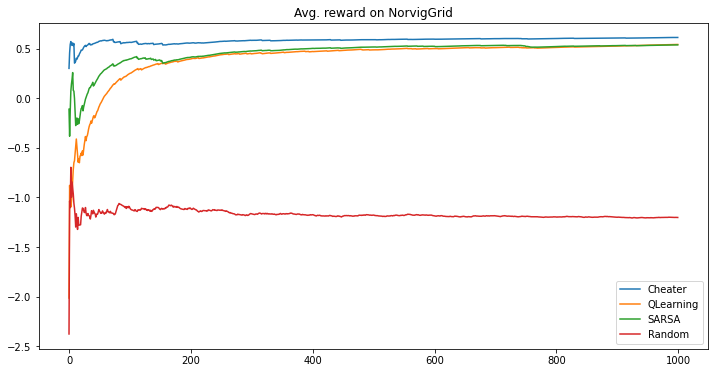

In [50]:
plt.figure(figsize=(12, 6))
for agent in agents_norvig:
    name = agent.name
    plt.plot(utils.cummean(returns_norvig[name]), label=name)
plt.legend()
plt.title(f"Avg. reward on {env_norvig.spec.name}")
plt.show()

In [12]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
env_cliff = gym.make("CliffWalking-v0")
config_cliff = AgentConfig(epsilon=0.5, lr=0.1, optimism=0)
n_runs = 1000
gamma = 1
seed = 1
args_cliff = (env_cliff, config_cliff, gamma, seed)
agents_cliff = [QLearning(*args_cliff), SARSA(*args_cliff)]
returns_cliff = {}
for agent in agents_cliff:
    returns_cliff[agent.name] = agent.train(n_runs)

100%|██████████| 1000/1000 [00:01<00:00, 708.59it/s]


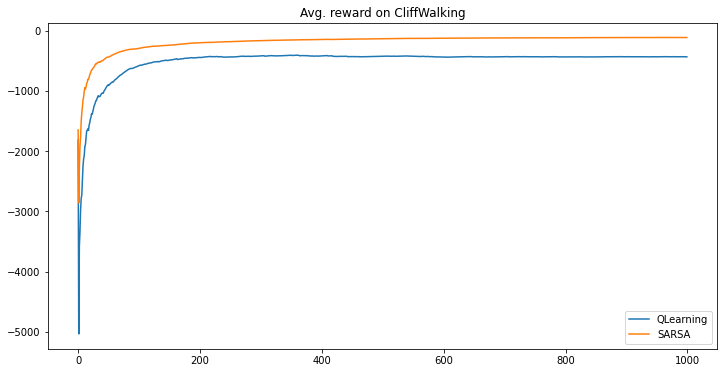

In [121]:
plt.figure(figsize=(12, 6))
for agent in agents_cliff:
    name = agent.name
    plt.plot(utils.cummean(returns_cliff[name]), label=name)
plt.legend()
plt.title(f"Avg. reward on {env_cliff.spec.name}")
plt.show()

In [122]:
def show_cliff_value(Q: Arr, title: Optional[str] = None):
    '''
    Displays the value of each state in CliffWalking-v0 given a Q-value table.
    '''
    V = Q.max(axis=-1).reshape(4, 12)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title)
    ax.imshow(V)
    ax.set_xticks([])
    ax.set_yticks([])
    for (i, j), z in np.ndenumerate(V):
        ax.text(
            j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )

def show_cliff_policy(Q: Arr):
    '''
    Displays the greedy policy for CliffWalking-v0 given a Q-value table.
    '''
    pi = Q.argmax(axis=-1).reshape((4, 12))
    objects = {(3, i): "black" for i in range(1, 11)}
    objects[(3, 0)] = "green"
    objects[(3, 11)] = "red"
    img = Image.new(mode="RGB", size=(1200, 400), color="white")
    draw = ImageDraw.Draw(img)
    for x in range(0, img.width+1, 100):
        draw.line([(x, 0), (x, img.height)], fill="black", width=4)
    for y in range(0, img.height+1, 100):
        draw.line([(0, y), (img.width, y)], fill="black", width=4)
    for x in range(12):
        for y in range(4):
            draw.regular_polygon((50+x*100, 50+y*100, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
            if (y, x) in objects:
                draw.regular_polygon((50+x*100, 50+y*100, 40), 4, fill=objects[(y, x)])
    display(img.resize((690, 230)))

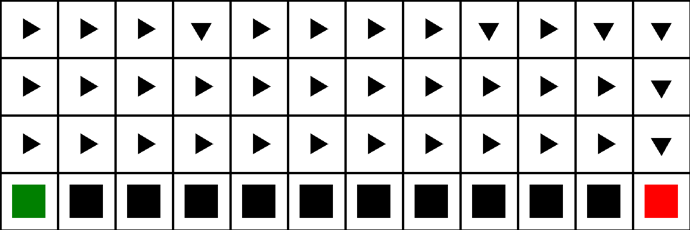

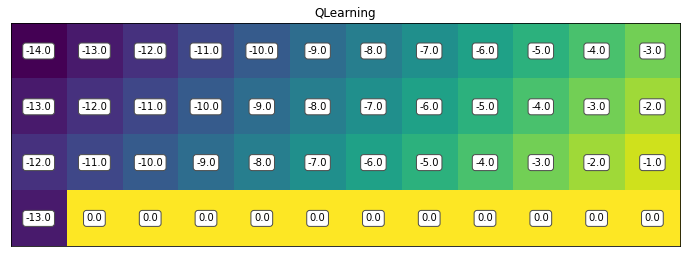

In [123]:
show_cliff_value(agents_cliff[0].Q, title="QLearning")
show_cliff_policy(agents_cliff[0].Q)

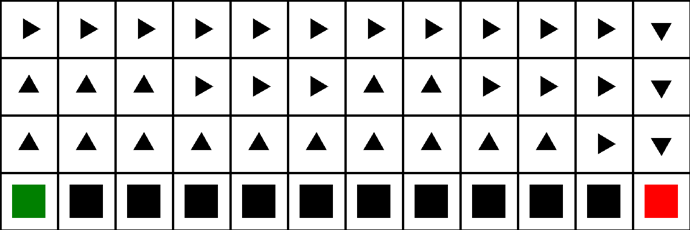

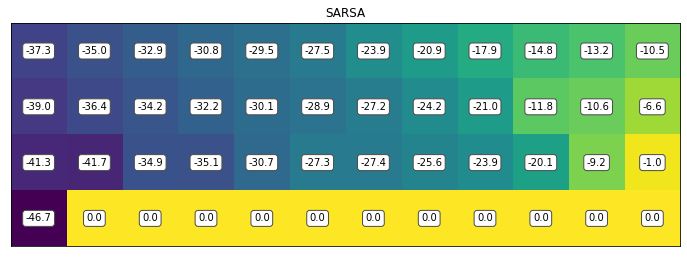

In [124]:
show_cliff_value(agents_cliff[1].Q, title="SARSA")
show_cliff_policy(agents_cliff[1].Q)

In [126]:
# Number of times each state is visited in 1000 episodes, QLearning
for row in agents_cliff[0].N.reshape(4, 12):
    print(row)

[ 777  904  979 1047 1085 1056 1041  958  843  711  588  465]
[1535 1776 1824 1783 1646 1513 1365 1194 1103  975  876  882]
[6374 4646 3495 2790 2286 1966 1761 1559 1444 1391 1392 1587]
[7430    0    0    0    0    0    0    0    0    0    0    0]


In [125]:
# Number of times each state is visited in 1000 episodes, SARSA
for row in agents_cliff[1].N.reshape(4, 12):
    print(row)

[2246 2430 2440 2399 2257 2294 2251 2152 1975 1858 1744 1817]
[2338 1392 1082  949  886  983  937  834  795  907 1161 2181]
[2345  506  254  216  221  249  244  203  187  206  384 1619]
[2598    0    0    0    0    0    0    0    0    0    0    0]
